# Model Validation
## いくつかのモデルに対して妥当性を評価する

データ前処理


In [1]:
# coding:utf-8
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

train = pd.read_csv('../data/train.csv')

####データ前処理####

#性別が扱いづらいので男性0、女性1とする
train.Sex = train.Sex.replace(['male','female'],[0,1])

# 欠損値の扱い
# Fareは中央値で埋める
train["Fare"].fillna(train.Fare.median(), inplace = True)
# Ageは敬称からそれぞれの敬称の中央値を埋め込む
age_name = train[["Age","Name"]]
na_omit_age_name = age_name.dropna()


honorific = ["Mr.", "Miss", "Mrs.", "Master", "Dr.", "Rev"]
honorific_age = [[],[],[],[],[],[]]
for i in range(0,len(na_omit_age_name)):
    if  train['Age'][i] > -1:
        if train['Name'][i].lower().find('mr.') > -1 :
                honorific_age[0].append(train['Age'][i])
        if train['Name'][i].lower().find('miss.') > -1:
                honorific_age[1].append(train['Age'][i])
        if train['Name'][i].lower().find('mrs.') > -1:
                honorific_age[2].append(train['Age'][i])
        if train['Name'][i].lower().find('master.') > -1:
                honorific_age[3].append(train['Age'][i])
        if train['Name'][i].lower().find('dr.') > -1:
                honorific_age[4].append(train['Age'][i])
        if train['Name'][i].lower().find('rev.') > -1:
            honorific_age[5].append(train['Age'][i])
    else:
        pass

print("[Median age]")
median = []
mean = []
for i in range(0,len(honorific_age)):
    median.append(np.median(honorific_age[i]))
    print(honorific[i],":",median[i])

print("\n[Average age]")
for i in range(0,len(honorific_age)):
    mean.append(sum(honorific_age[i])/len(honorific_age[i]))
    print(honorific[i],":", mean[i])

honorific_dict ={
    "Mr.": 0,
    "Miss.": 1,
    "Mme.": 1,
    "Mlle.": 1,
    "Master.": 2,
    "Mrs.": 3,
    "Ms.": 3,
    "Dr.": 4,
    "Rev.": 4,
    "Capt.": 4,
    "Col.": 4,
    "Major.": 4,
    "Don.": 5,
    "Jonkheer.": 5,
    "Sir.": 5,
    "Dona.": 5,
    "Countess.": 5,
    "Lady.": 5
}

train["Honorific"] = train["Name"].str.extract('([A-Za-z]+\.)',expand=False).map(honorific_dict)

age_insert_list = median
print(median)
age_byHono = []
for row in range(0,len(train)):
    if train["Age"][row] > 0:
        age_byHono.append(train["Age"][row])
        pass
    else:
         age_byHono.append(age_insert_list[train["Honorific"][row]])
train["Age_by_Honorific"] = age_byHono

#新たなカラムFamilySize,IsAlineを追加
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
for train in [train]:
    train['IsAlone'] = 0
    train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
    
#IsChild
for train in [train]:
    train['IsChild'] = 0
    train.loc[train['Age_by_Honorific'] <= 5, 'IsChild'] = 1
    
#IsFemaleOrChild
for train in [train]:
    train['IsForC'] = 0
    train.loc[train['Sex'] == 1 , 'IsForC'] = 1
    train.loc[train['IsChild'] == 1 , 'IsForC'] = 1

[Median age]
Mr. : 30.0
Miss : 21.0
Mrs. : 34.5
Master : 3.5
Dr. : 44.0
Rev : 52.5

[Average age]
Mr. : 33.021875
Miss : 22.0203252033
Mrs. : 34.95
Master : 4.82291666667
Dr. : 40.6
Rev : 51.0
[30.0, 21.0, 34.5, 3.5, 44.0, 52.5]


In [2]:
#Pclass
pclass_dummies_titanic  = pd.get_dummies(train['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
train.drop(['Pclass'],axis=1,inplace=True)
train = train.join(pclass_dummies_titanic)

In [3]:
#droplist_best = ["Name", "Age","SibSp", "Parch","Ticket","Cabin", "Age_by_Honorific","Embarked","IsAlone", "Honorific"]
droplist = ["Name", "Age","SibSp", "Parch","Ticket","Cabin","Embarked", "Fare", "IsChild","Honorific","IsAlone"]
train_new = train.drop(droplist, axis=1)

####学習####
train_data = train_new.values
col = train_new.columns.values[2:]
xs = train_data[:,2:]
labels = train_data[:, 1]



# 相関性の確認
すべての特徴量の相関性を可視化し特徴量選出のヒントとする
加えた新たな特徴量は以下の通り
* Honorific : 敬称別ナンバー [0,5]
* Age_by_Honorific: 敬称から年齢の欠損値を埋めた値
* FamilySize: 家族の数
* IsAlone: 一人であるかどうか
* IsChild: 子供（5歳以下）であるかどうか
* IsForC: 子供または女性であるかどうか
* Class_1~3: Pclassのダミー変数

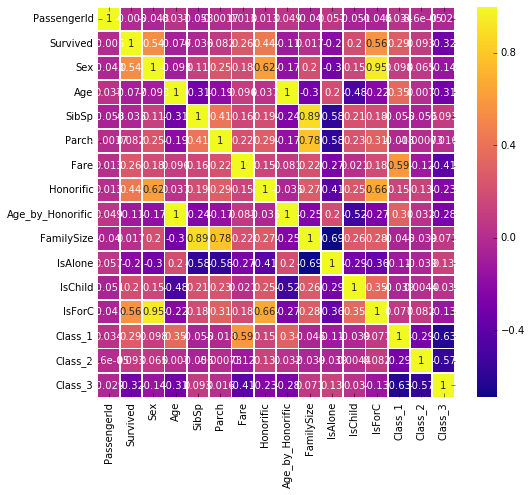

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.figure(figsize=(8,7)) #heatmap size
sns.heatmap(train.corr(), annot=True, cmap="plasma", linewidths=.8)
#annot: 値を表示するかどうか, linewidths: しきい線

# 訓練データを分割しモデルごとにaccuracy, presicion, recallを比較
今回比較を行ったのは以下の分類器
* Random Forest(RF)
* Decision Tree(DT)
* Support Vector Machine(SVM)
* Naive Bayes(NB)


In [5]:
clf_no_split_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)
clf_no_split_rf.fit(xs, labels)

X_train, X_val, y_train, y_val = train_test_split(xs, labels, train_size=0.8, random_state=1)
clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=9, max_features='auto', max_leaf_nodes=None,
#             min_samples_leaf=1, min_samples_split=12,
#             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
#             oob_score=False, random_state=3, verbose=0, warm_start=False)
clf_rf.fit(X_train, y_train)

print("Feature: ",col)
print("[Random Forest]")
# Feature Importance
fti = clf_rf.feature_importances_   
print('Feature Importances:')
for i, feat in enumerate(col):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

from sklearn.metrics import accuracy_score, precision_score, recall_score

predict = clf_rf.predict(X_val)
print("accuracy_score: ", accuracy_score(y_val, predict))
print("precision_score:", precision_score(y_val, predict))
print("recall: ", recall_score(y_val, predict))

from sklearn import tree
clf_dt = tree.DecisionTreeClassifier(max_depth=3)
clf_dt.fit(X_train, y_train)
print("\n[DT]")
predict = clf_dt.predict(X_val)
print("accuracy_score: ", accuracy_score(y_val, predict))
print("precision_score:", precision_score(y_val, predict))
print("recall: ", recall_score(y_val, predict))


from sklearn import svm
print("\n[SVM]")
clf_svm = svm.SVC(kernel='rbf', C=10, gamma=0.1)
clf_svm.fit(X_train, y_train)
predict = clf_svm.predict(X_val)
print("accuracy_score: ", accuracy_score(y_val, predict))
print("precision_score:", precision_score(y_val, predict))
print("recall: ", recall_score(y_val, predict))

#NB
print("\n[NB]")
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
predict = clf_nb.predict(X_val)
print("accuracy_score: ", accuracy_score(y_val, predict))
print("precision_score:", precision_score(y_val, predict))
print("recall: ", recall_score(y_val, predict))


Feature:  ['Sex' 'Age_by_Honorific' 'FamilySize' 'IsForC' 'Class_1' 'Class_2'
 'Class_3']
[Random Forest]
Feature Importances:
	Sex                  : 0.202526
	Age_by_Honorific     : 0.165056
	FamilySize           : 0.111205
	IsForC               : 0.294474
	Class_1              : 0.049593
	Class_2              : 0.024927
	Class_3              : 0.152220
accuracy_score:  0.77094972067
precision_score: 0.807692307692
recall:  0.575342465753

[DT]
accuracy_score:  0.804469273743
precision_score: 0.816666666667
recall:  0.671232876712

[SVM]
accuracy_score:  0.776536312849
precision_score: 0.779661016949
recall:  0.630136986301

[NB]
accuracy_score:  0.804469273743
precision_score: 0.816666666667
recall:  0.671232876712


### [memo]
特徴量のとり方次第ではあるが基本的にRandomForestが高い
結果的なベストなパラメータ、特徴量は以下の通り


```
X_train, X_val, y_train, y_val = train_test_split(xs, labels, train_size=0.8, random_state=1)

clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)


Feature:  ['Pclass' 'Sex' 'Fare' 'FamilySize']
[Random Forest]
Feature Importances:
	Pclass               : 0.169919
	Sex                  : 0.459712
	Fare                 : 0.257617
	FamilySize           : 0.112752
accuracy_score:  0.815642458101
precision_score: 0.884615384615
recall:  0.630136986301
```

### Kaggle Scoreは0.79425


In [6]:
#学習
#forest = forest.fit(xs, y)
test_df = pd.read_csv("../data/test.csv").replace(["male","female"],[0,1])

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
test_df.drop(['Pclass'],axis=1,inplace=True)
test_df    = test_df.join(pclass_dummies_test)


#欠損値の補完
test_df["Fare"].fillna(train.Fare.median(), inplace = True)
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1
for test_df in [test_df]:
    test_df['IsAlone'] = 0
    test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1
test_df["Honorific"] = train["Name"].str.extract('([A-Za-z]+\.)',expand=False).map(honorific_dict)


age_byHono = []
#　年齢が欠損してれば"Honorific"から対応する年齢を埋め込む
for row in range(0,len(test_df)):
    if test_df["Age"][row] > 0:
        age_byHono.append(test_df["Age"][row])
    else:
         age_byHono.append(age_insert_list[test_df["Honorific"][row]])
            
test_df["Age_by_Honorific"] = age_byHono

#IsChild
for row in range(0,len(test_df)):
    test_df['IsChild'] = 0
    test_df.loc[test_df['Age_by_Honorific'] <= 5, 'IsChild'] = 1 
#IsFemaleOrChild
for test_df in [test_df]:
    test_df['IsForC'] = 0
    test_df.loc[test_df['Sex'] == 1 , 'IsForC'] = 1
    test_df.loc[test_df['IsChild'] == 1 , 'IsForC'] = 1


test_df_arranged = test_df.drop(droplist, axis=1)
col = test_df_arranged.columns.values[1:]

test_data = test_df_arranged.values
xs_test = test_data[:, 1:]
output = clf_no_split_rf.predict(xs_test)

zip_data = zip(test_data[:,0].astype(int), output.astype(int))
predict_data = list(zip_data)

In [7]:
import csv
fname = "../result/result_nosp.csv"
with open(fname, "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_data[:,0].astype(int), output.astype(int)):
        writer.writerow([pid, survived])
print("Done. Saved as", fname)

Done. Saved as ../result/result_nosp.csv
